In [16]:
%run hapclust_utils.ipynb
import cartopy; print('cartopy', cartopy.__version__)
import cartopy.crs as ccrs
import cartopy.feature as cfeature

cartopy 0.15.1


In [17]:
#grab these from ag1000g - no need to bring in the meta data file
df_lonlat = pd.DataFrame()
df_lonlat['country'] = ['Angola', 'Burkina Faso', 'Cameroon', 'Gabon', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Uganda']
df_lonlat['longitude'] = [13.291000, -4.413900, 13.936844, 9.455000, -9.675065, -15.582000, 39.824614, 34.026000]
df_lonlat['latitude'] = [-8.821000, 11.206500, 4.937851, 0.384000, 8.887097, 11.891000, -3.702068, 0.770000]
df_lonlat = df_lonlat.set_index('country')

In [18]:
#check
df_lonlat.loc['Angola']

longitude    13.291
latitude     -8.821
Name: Angola, dtype: float64

In [19]:
#check
for country, row in df_lonlat.iterrows():
    print(country, row.latitude, row.longitude)

Angola -8.821 13.291
Burkina Faso 11.2065 -4.4139
Cameroon 4.937851 13.936844
Gabon 0.384 9.455
Guinea 8.887097 -9.675065
Guinea-Bissau 11.891 -15.582
Kenya -3.702068 39.824614
Uganda 0.77 34.026


In [20]:
crs_lonlat = ccrs.PlateCarree()

In [21]:
ratios=np.asarray([0.5, 0.5])


In [22]:
sum(ratios)

1.0

In [23]:
def draw_pie(ax, ratios, X, Y, colors, offset=(-300000, 300000), size=1000, lw=0.2):
    
    N = len(ratios)
    assert ratios.sum() == 1.0, "ratios must sum to 1.0 not %s" % ratios.sum()

    xy = []
    a, b = offset[0]*1e6, offset[1]*1e6
    start = 0.
    ix = list()
    # build xy
    for i, ratio in enumerate(ratios):
        if ratio > 0:
            x = [0] + np.cos(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 
                                         int(200*ratio))).tolist()
            y = [0] + np.sin(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 
                                         int(200*ratio))).tolist()
            xy1 = list(zip(x,y))
            xy.append(xy1)
            ix.append(i)
            start += ratio

    # if just one segment, then draw a circle.
    if len(xy) == 1:
        ax.scatter([X + a],[Y + b] , marker="o", s=size, 
                   facecolor=colors[ix[0]], linewidths=lw,
                   edgecolor="black", zorder=20)    
    else:
        for idx, xyi in zip(ix, xy):
            ax.scatter([X + a],[Y + b] , marker=(xyi, 0), s=size, alpha=1.0,
                       facecolor=colors[idx], edgecolor="black", linewidths=lw, zorder=20)
    
    
    
    # given the offset, draw a triangle pointed at the origin (0, 0)
    scaledg = np.abs([a, b]).mean()
    grad = a/scaledg, b/scaledg
    hypot = np.sqrt(a**2 + b**2)
    
    A = np.array(grad)
    const = 0.15
    alength = np.sqrt(A[0]**2 + A[1]**2)
    
    B = A * alength * const
    B1 = np.array([-B[1], B[0]])
    B2 = np.array([B[1], -B[0]])
    A1 = A + B1
    A2 = A + B2
        
    pointer = [(0, 0), A1, A2]
    ax.scatter([X], [Y],
               marker=(pointer, 0), 
               s=scaledg/220, facecolor="grey", edgecolor="none", linewidth=0.5, zorder=9)

/home/chris/Git/agam-vgsc-report/dependencies/miniconda/envs/agam-vgsc-report/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in double_scalars
/home/chris/Git/agam-vgsc-report/dependencies/miniconda/envs/agam-vgsc-report/lib/python3.5/site-packages/matplotlib/markers.py:292: RuntimeWarning: invalid value encountered in absolute
  rescale = max(np.max(np.abs(verts[:, 0])),
/home/chris/Git/agam-vgsc-report/dependencies/miniconda/envs/agam-vgsc-report/lib/python3.5/site-packages/matplotlib/markers.py:293: RuntimeWarning: invalid value encountered in absolute
  np.max(np.abs(verts[:, 1])))


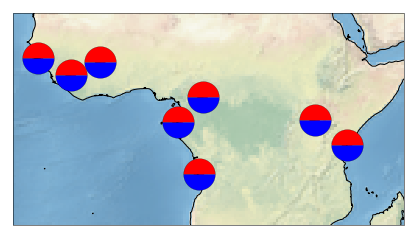

In [24]:
extent_lonlat = (-20, 50, -18, 20)

subplot_kw = dict(projection=crs_lonlat)
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=subplot_kw)
ax.set_extent(extent_lonlat, crs=crs_lonlat)
ax.coastlines(resolution='50m', linewidth=.5)
ax.stock_img()
#ax.add_feature(cfeature.BORDERS, lw=.5)
#ax.add_feature(cfeature.LAKES)
#ax.margins(0)
for country, row in df_lonlat.iterrows():
    ax.add_patch(plt.Circle((row.longitude, row.latitude), radius=.9, color='r'))
    draw_pie(ax=ax, ratios=ratios, X=row.longitude , Y=row.latitude, colors=['r', 'b'], size=1000, offset=(0, 0));

# what we need to get the haplogroup map sorted!
- We got the indices/collection sites of the indv in each haplogroup to make the networks
- we just need to know:
    - how many haplotypes at each site
    - what proportion belong to each of the 10 haplogroups (colours from figure 2)
    - what proportion are 'non haplogroup'

In [26]:
#setup data - pinched from hapclust_demo
callset = h5py.File('../data/ag1000g.phase1.AR3.1.haplotypes.specific_regions.2L_2358158_2431617.h5',
                    mode='r')
region_vgsc = SeqFeature('2L', 2358158, 2431617)
genotypes = allel.GenotypeArray(callset['2L/calldata/genotype'])
haplotypes = genotypes.to_haplotypes()
pos = allel.SortedIndex(callset['2L/variants/POS'])
loc = pos.locate_range(region_vgsc.start, region_vgsc.end)
h_vgsc = haplotypes[loc]
pos_995S = 2422651
pos_995F = 2422652
loc_995S = haplotypes[pos.locate_key(pos_995S)] == 1
loc_995F = haplotypes[pos.locate_key(pos_995F)] == 1
h_vgsc_995F = h_vgsc.compress(loc_995F, axis=1)
h_vgsc_995S = h_vgsc.compress(loc_995S, axis=1)
sample_ids = callset['2L']['samples'][:]
hap_ids = np.array(list(itertools.chain(*[[s + b'a', s + b'b'] for s in sample_ids])))
hap_ids_995F = hap_ids[loc_995F]
hap_ids_995S = hap_ids[loc_995S]
tbl_haplotypes = etl.fromtsv('../data/ag1000g.phase1.AR3.1.haplotypes.meta.txt')
hap_pops = np.array(tbl_haplotypes.values('population'))
hap_pops_995S = hap_pops[loc_995S]
hap_pops_995F = hap_pops[loc_995F]
# need to use named colors for graphviz
pop_colors = {
    'AOM': 'brown',
    'BFM': 'firebrick1',
    'GWA': 'goldenrod1',
    'GNS': 'cadetblue1',
    'BFS': 'deepskyblue',
    'CMS': 'dodgerblue3',
    'UGS': 'palegreen',
    'GAS': 'olivedrab',
    'KES': 'grey47',
    'colony': 'black'
}
#associates pop colours with haps
hap_colors = np.array([pop_colors[p] for p in hap_pops])
hap_colors_995S = np.array([pop_colors[p] for p in hap_pops_995S])
hap_colors_995F = np.array([pop_colors[p] for p in hap_pops_995F])

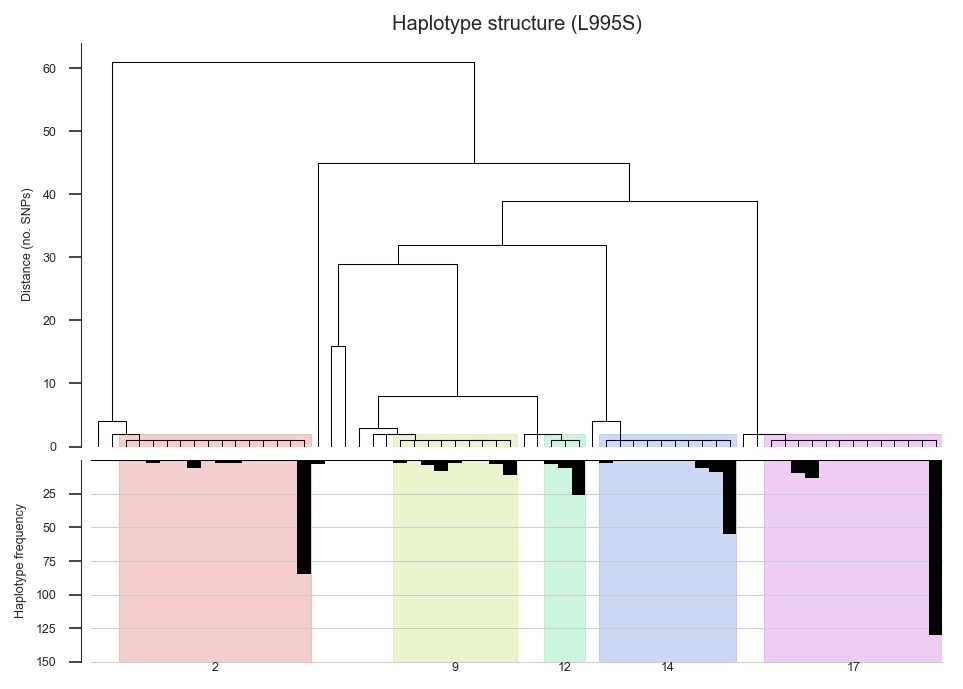

In [37]:
#use the dendro cutting to get the pop freqs for each of the S and F clusters
cut_height = 2
fig, ax_dend, ax_freq, cluster_spans_995S, leaf_obs_995S = fig_haplotypes_clustered(h_vgsc_995S, cut_height=cut_height, dpi=150, 
                                                                          highlight_clusters=5, label_clusters=5)
ax_dend.set_title('Haplotype structure (L995S)')
ax_dend.set_ylabel('Distance (no. SNPs)')
ax_freq.set_ylabel('Haplotype frequency');

In [53]:
#indices of haplotypes, relative to the hap_pops_995S array - use this to get freqs of each pop
cluster_spans_995S[17][2]

array([  2,   6,   8,   9,  10,  12,  13,  14,  18,  20,  22,  24,  26,
        27,  30,  31,  32,  34,  44,  46,  48,  49,  52,  53,  54,  56,
        58,  60,  62,  66,  67,  68,  69,  70,  72,  74,  76,  78,  80,
        81,  84,  90,  92,  93,  96,  97,  98,  99, 102, 104, 105, 106,
       108, 110, 112, 116, 117, 118, 120, 124, 125, 130, 132, 134, 136,
       138, 142, 143, 146, 150, 152, 153, 154, 155, 156, 160, 161, 162,
       166, 168, 170, 174, 175, 178, 179, 180, 182, 190, 191, 192, 194,
       196, 198, 200, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252,
       253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
       266, 267, 268, 269, 270, 271, 272])

In [72]:
#count function - MAKE TABLE
#make lists (columns) for each cluster so that we can turn these into a df 

#DO THIS


def pop_count(hap_pops, cluster_spans, cov):
    cov_ind = hap_pops.take(cluster_spans[cov][2])
    unique, counts = np.unique(cov_ind, return_counts=True)
    for u, c in zip(unique, counts):
        print(cov, u, c)

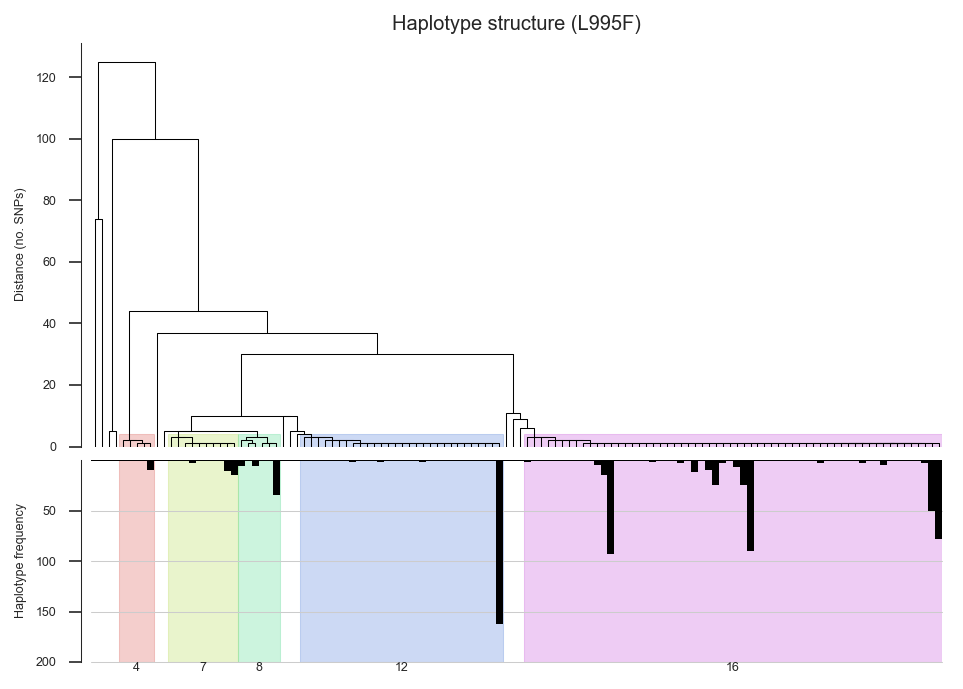

In [74]:
#and for F
cut_height = 4
fig, ax_dend, ax_freq, cluster_spans_995F, leaf_obs_995F = fig_haplotypes_clustered(h_vgsc_995F, cut_height=cut_height, dpi=150, 
                                                                          highlight_clusters=5, label_clusters=5)
ax_dend.set_title('Haplotype structure (L995F)')
ax_dend.set_ylabel('Distance (no. SNPs)')
ax_freq.set_ylabel('Haplotype frequency');

In [76]:
for cov in 17, 14, 12, 9, 2:
    pop_count(hap_pops_995S, cluster_spans_995S, cov)

17 KES 66
17 UGS 97
14 CMS 8
14 GAS 70
12 CMS 35
9 CMS 33
2 UGS 106


In [75]:
for cov in 16, 12, 8, 7, 4:
    pop_count(hap_pops_995F, cluster_spans_995F, cov)

16 AOM 97
16 BFM 117
16 BFS 162
16 CMS 32
16 GNS 62
16 colony 5
12 CMS 169
12 GAS 24
8 CMS 50
7 CMS 20
7 GAS 16
4 CMS 14


### now we need to know how many samples are at each site and what proportion are haplogroups.

In [71]:
#total haps in each pop
unique, counts = np.unique(hap_pops, return_counts=True)
for u, c in zip(unique, counts):
    print(u, c)

AOM 120
BFM 138
BFS 162
CMS 550
GAS 112
GNS 62
GWA 92
KES 88
UGS 206
colony 16


In [69]:
#check total
sum(counts)

1546